In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import logging
import seaborn as sns
from pathlib import Path
logging.getLogger('matplotlib.font_manager').disabled = True
import os
import numpy as np

from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

clustering_method = 'kMeans' # Options: 'kProt', 'kMed', 'kMeans'
dataset = 'SWW'  # Options: 'SWW', 'GroupE'
building_type = 'house'  # Options: 'flat', 'house'

In [8]:

data_type = (f'hourly_avg_clustering_{clustering_method}_{building_type}')
# Load the key Excel file
key_path = (f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/00_SWW_ID_smartmeter.xlsx")
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = (f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/Survey_Data.xlsx")
# Read without headers, skipping first 4 rows, and limiting to 1500 rows
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None,dtype={10: str})
cols_to_extract = [10, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 154, 127, 129, 155, 131, 128, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]
extracted_df = df.iloc[:, cols_to_extract]

# Assign own column names
extracted_df.columns = ['resident_id', 'Building Type', 'Heating', 'Water Heating', 
                        'Solar Panels', 'Electric Vehicle', 'Heat Pump', 'Individual Electric Boiler', 
                        'Individual Washing Machine', 'Home Battery','Number of Residents',
                        'Number of Days at Home','Age','Education', 'Employment', 'Tenant Type',
                        'Income','DR scenario', 'DR heating', 'DR hot water', 'DR EV', 'DR appliances', 
                        'Control Technologies','Optimal Usage Time', 'Automated DR', 'Emergency DR', 'LEC']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_resident_ids = extracted_df_pl["resident_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique resident_id count: {unique_resident_ids}")

if total_rows > unique_resident_ids:
    print(f"There are {total_rows - unique_resident_ids} duplicate resident_id entries.")
else:
    print("No duplicates found in resident_id column.")

Total rows: 1500
Unique resident_id count: 1500
No duplicates found in resident_id column.


In [9]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/{data_type}.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "resident_id",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="resident_id",
    how="left"
)
result_df = result_df.select([
    "resident_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("resident_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

print(cluster_summary)

shape: (6, 4)
┌─────────┬────────────────┬─────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_total_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                         ┆ ---                         │
│ i64     ┆ u32            ┆ f64                         ┆ f64                         │
╞═════════╪════════════════╪═════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 86             ┆ 8995.22                     ┆ 13.59                       │
│ 2       ┆ 46             ┆ 3279.48                     ┆ 5.69                        │
│ 3       ┆ 124            ┆ 5302.11                     ┆ 9.25                        │
│ 4       ┆ 68             ┆ 9799.48                     ┆ 16.19                       │
│ 5       ┆ 69             ┆ 10112.88                    ┆ 15.51                       │
│ 6       ┆ 83             ┆ 10163.86                    ┆ 18.21                       │
└──────

In [10]:
extracted_pl_df = pl.from_pandas(extracted_df)
print(extracted_pl_df.shape)

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

extracted_pl_df = extracted_pl_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

# First join: attach survey columns
joined = result_df.join(
    extracted_pl_df.select([
    "resident_id",
    "Building Type",
    "Heating",
    "Water Heating",
    "Heat Pump",
    "Solar Panels",
    "Electric Vehicle",
    'Home Battery',
    'Individual Electric Boiler',
    'Individual Washing Machine',
    'Number of Residents',
    'Number of Days at Home',
    'Age',
    'Education',
    'Employment',
    "Tenant Type",
    "Income",
    "DR scenario",
    "DR heating",
    "DR hot water",
    "DR EV",
    "DR appliances",
    'Control Technologies',
    'Optimal Usage Time',
    'Automated DR',
    'Emergency DR',
    'LEC'
    ]),
    on="resident_id",
    how="left"
)

# Second join: attach consumption
joined = joined.join(
    alle_mittelwerte_df.select(["resident_id", "bruttolastgang_kwh_sum"]),
    on="resident_id",
    how="left"
)

# Define the order of columns for the final DataFrame
final_df = joined.select([
    "resident_id",                
    "bruttolastgang_kwh_sum",  
    "cluster",                 
    "Building Type",
    "Heating",
    "Water Heating",
    "Heat Pump",
    "Solar Panels",
    "Electric Vehicle",
    'Home Battery',
    'Individual Electric Boiler',
    'Individual Washing Machine',
    'Number of Residents',
    'Number of Days at Home',
    'Age',
    'Education',
    'Employment',
    "Tenant Type",
    "Income",
    "DR scenario",
    "DR heating",
    "DR hot water",
    "DR EV",
    "DR appliances",
    'Control Technologies',
    'Optimal Usage Time',
    'Automated DR',
    'Emergency DR',
    'LEC'
])

(1500, 27)


In [28]:
def categorize_consumption(value):
    if value < 5000:
        return "0-5 MWh"
    elif value < 10000:
        return "5-10 MWh"
    elif value < 15000:
        return "10-15 MWh"
    elif value < 20000:
        return "15-20 MWh"
    elif value < 25000:
        return "20-25 MWh"
    else:
        return "25+ MWh"

final_df = final_df.with_columns(
    pl.col("bruttolastgang_kwh_sum")
      .map_elements(categorize_consumption, return_dtype=pl.Utf8)
      .alias("consumption_category")
)

print(final_df)

final_df.write_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Survey/hourly_avg_clustering_category_{data_type}.csv')

print(final_df.shape)


shape: (476, 30)
┌────────────┬───────────┬─────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ house_id   ┆ bruttolas ┆ cluster ┆ Building  ┆ … ┆ Automated ┆ Emergency ┆ LEC       ┆ consumpti │
│ ---        ┆ tgang_kwh ┆ ---     ┆ Type      ┆   ┆ DR        ┆ DR        ┆ ---       ┆ on_catego │
│ str        ┆ _sum      ┆ i64     ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ry        │
│            ┆ ---       ┆         ┆ str       ┆   ┆ str       ┆ str       ┆           ┆ ---       │
│            ┆ f64       ┆         ┆           ┆   ┆           ┆           ┆           ┆ str       │
╞════════════╪═══════════╪═════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 5515.587  ┆ 1       ┆ House     ┆ … ┆ No Inform ┆ No Inform ┆ /         ┆ 5-10 MWh  │
│ 3450000000 ┆           ┆         ┆           ┆   ┆ ation     ┆ ation     ┆           ┆           │
│ 0000000046 ┆           ┆         ┆           ┆   ┆           ┆          

In [11]:
%%skip

#Identify the number of households with high consumption and EVs

count = final_df.filter(
    (pl.col('bruttolastgang_kwh_sum') > 30000) &
    (pl.col('Electric Vehicle') == 'yes')
).height

print(count)

count = final_df.filter(
    (pl.col('bruttolastgang_kwh_sum') > 30000)
).height

print(count)

In [12]:
%%skip

dr_columns = ['DR heating', 'DR hot water', 'DR EV', 'DR appliances']
dr_titles = ['Heating', 'Hot water', 'EV', 'Appliances']
dr_category_order = ['No', 'Yes']
dr_category_colors = {'No': 'blue', 'Yes': 'orange'}
n_clusters = len(clusters)
n_dr = len(dr_columns)
bar_width = 0.18
intra_cluster_gap = 0.18  # Space between DR bars within a cluster
x_gap = 0.50  # Space between clusters


dr_scenarios = ['1','2','3']

print(dr_scenarios)


clusters = final_df['cluster'].unique()


n_scenarios = len(dr_scenarios)
fig, axs = plt.subplots(n_scenarios, 1, figsize=(2 + n_clusters * n_dr * 1.0, n_scenarios * 7), sharex=True)

if n_scenarios == 1:
    axs = [axs]

for plot_idx, dr_scenario in enumerate(dr_scenarios):
    scenario_df = final_df.filter(pl.col('DR scenario') == dr_scenario)
    clusters = scenario_df['cluster'].unique()
    n_clusters = len(clusters)
    n_dr = len(dr_columns)
    bar_data = np.zeros((n_clusters, n_dr, len(dr_category_order)))
    for cluster_idx, cl in enumerate(clusters):
        cluster_subset = scenario_df.filter(pl.col('cluster') == cl)
        for dr_idx, col in enumerate(dr_columns):
            answers = cluster_subset[col]
            valid_answers = answers.filter(~(answers == "No Information"))
            total = len(valid_answers)
            category_counts = [(valid_answers == cat).sum() for cat in dr_category_order]
            fracs = [count / total if total > 0 else 0 for count in category_counts]
            bar_data[cluster_idx, dr_idx, :] = fracs

    ax = axs[plot_idx]
    group_width = n_dr * (bar_width + intra_cluster_gap) - intra_cluster_gap + x_gap
    bar_positions = []
    for cluster in range(n_clusters):
        base_x = cluster * group_width
        for dr in range(n_dr):
            bar_x = base_x + dr * (bar_width + intra_cluster_gap)
            bar_positions.append(bar_x)
    bottom = np.zeros(n_clusters * n_dr)
    for cat_idx, cat in enumerate(dr_category_order):
        y_values = bar_data[:, :, cat_idx].flatten()
        bars = ax.bar(bar_positions, y_values, bottom=bottom, width=bar_width, color=dr_category_colors[cat],
                      label=cat if plot_idx == 0 and cat_idx == 0 else "")
        bottom += y_values
    for cluster in range(n_clusters):
        base_x = cluster * group_width
        for dr in range(n_dr):
            bar_x = base_x + dr * (bar_width + intra_cluster_gap) + bar_width / 2 - 0.08
            ax.text(bar_x, 1.07, dr_titles[dr], ha='center', va='bottom', fontsize=14, fontweight='bold', rotation=90)
        group_center = base_x + ((n_dr * (bar_width + intra_cluster_gap) - intra_cluster_gap) / 2) - bar_width / 2
        ax.text(group_center, -0.1, f'Cluster {clusters[cluster]}', ha='center', va='top', fontsize=20)
    ax.set_ylim(0, 1.5)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_title(f"Scenario {dr_scenario}", pad=20, size=20)
    ax.set_ylabel("Fraction within Cluster")
    ax.set_xticks([])

# Add a single legend below all plots in the center
handles = [plt.Rectangle((0,0),1,1, color=dr_category_colors[cat]) for cat in dr_category_order]
labels = dr_category_order
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=5, fontsize='xx-large')

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust for space for the legend
plt.savefig(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Survey/DR_{data_type}_scenarios_combined_vertical.png')
plt.show()



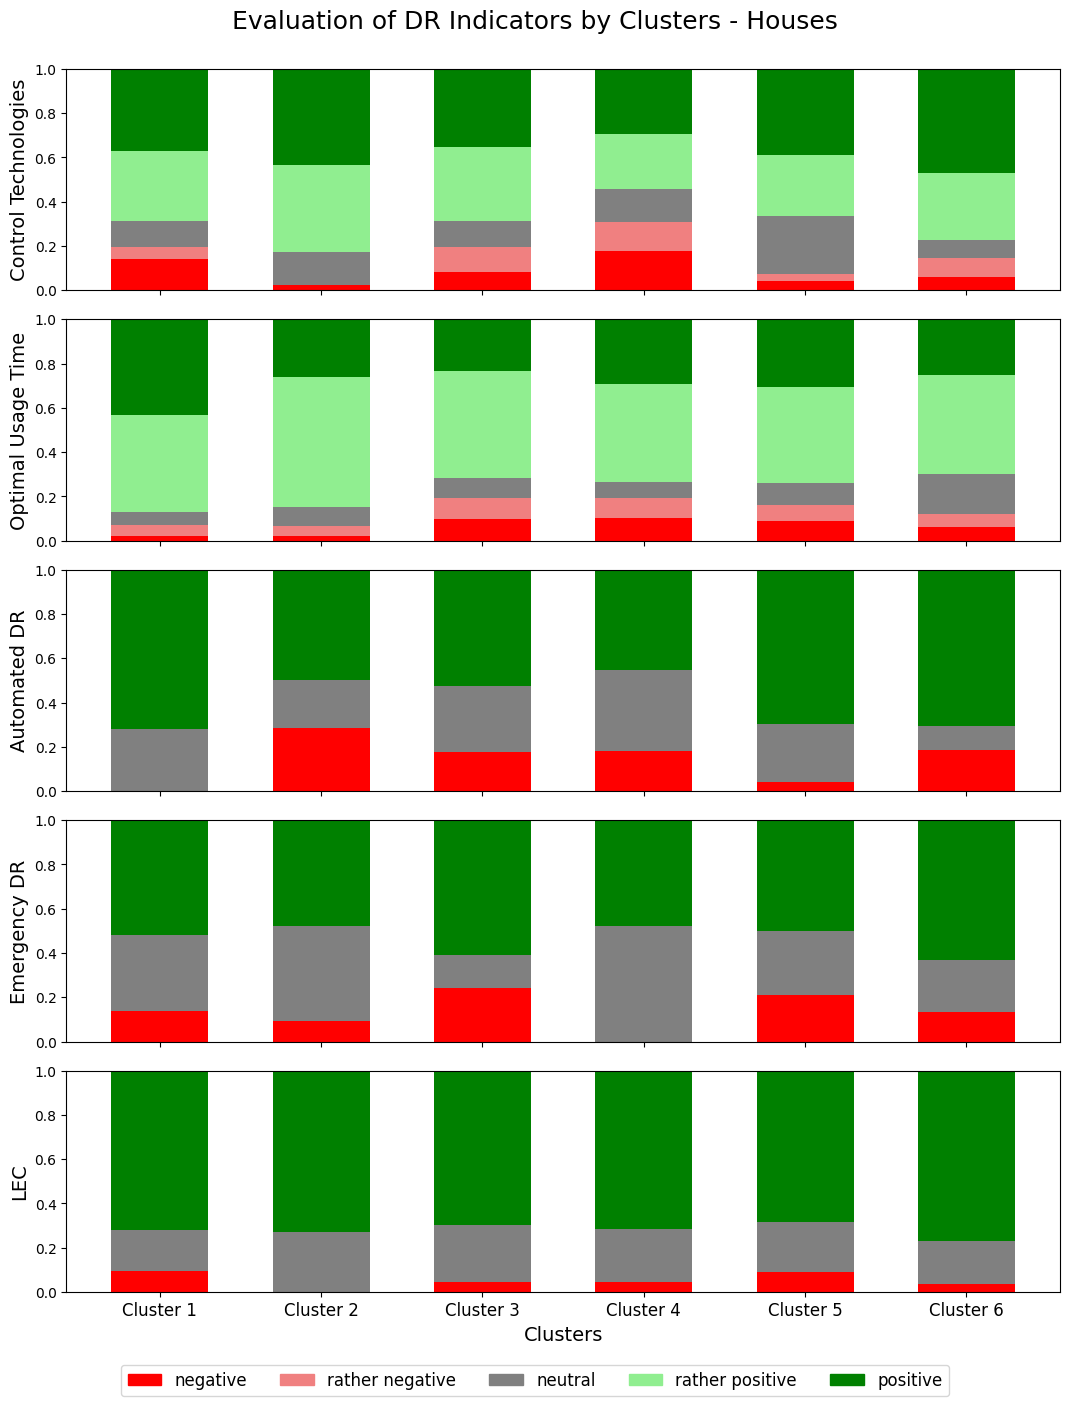

In [13]:
import matplotlib.pyplot as plt
import numpy as np


dr_columns = ['Control Technologies', 'Optimal Usage Time', 'Automated DR', 'Emergency DR', 'LEC']
dr_category_order = ['- -','-', '/', '+','+ +']
dr_category_colors = {'- -':'red','-':'lightcoral', '/': 'grey', '+': 'lightgreen','+ +': 'green'}

dr_legend = ['negative', 'rather negative', 'neutral', 'rather positive', 'positive']

clusters = final_df['cluster'].unique()
n_clusters = len(clusters)
n_dr = len(dr_columns)
bar_width = 0.18
intra_cluster_gap = 0.12  # space between bars within cluster groups

bar_data = np.zeros((n_clusters, n_dr, len(dr_category_order)))
for cluster_idx, cl in enumerate(clusters):
    cluster_subset = final_df.filter(pl.col('cluster') == cl)
    for dr_idx, col in enumerate(dr_columns):
        answers = cluster_subset[col]
        valid_answers = answers.filter(~(answers == "No Information"))
        total = len(valid_answers)
        category_counts = [(valid_answers == cat).sum() for cat in dr_category_order]
        fracs = [count / total if total > 0 else 0 for count in category_counts]
        bar_data[cluster_idx, dr_idx, :] = fracs

fig, axs = plt.subplots(n_dr, 1, figsize=(6 + n_clusters*0.8, n_dr*3), sharex=True)

if n_dr == 1:
    axs = [axs]

cluster_positions = np.arange(n_clusters) * (bar_width + intra_cluster_gap)
bar_middle_positions = cluster_positions # center of bars

for dr_idx, ax in enumerate(axs):
    bottom = np.zeros(n_clusters)
    for cat_idx, cat in enumerate(dr_category_order):
        values = bar_data[:, dr_idx, cat_idx]
        ax.bar(cluster_positions, values, bottom=bottom, width=bar_width, color=dr_category_colors[cat],
               label=cat if dr_idx == 0 else "")
        bottom += values

    ax.set_ylim(0, 1)
    ax.set_ylabel(dr_columns[dr_idx], fontsize=14)
    ax.grid(False, axis='y')

axs[-1].set_xticks(bar_middle_positions)
axs[-1].set_xticklabels([f'Cluster {cl}' for cl in clusters], rotation=0, ha='center', fontsize=12)
axs[-1].set_xlabel('Clusters', fontsize=14)

# Main title for entire figure
fig.suptitle(f'Evaluation of DR Indicators by Clusters - {building_type.capitalize()}s', fontsize=18, y=0.95)

# Legend below all subplots
handles = [plt.Rectangle((0,0),1,1,color=dr_category_colors[cat]) for cat in dr_category_order]
labels = dr_legend
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, +0.02), ncol=len(dr_category_order), fontsize='large')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Survey/DR_{data_type}.png')
plt.show()

Heating,Other,Boiler,Heat Pump
cluster,,,
1,0.151,0.012,0.837
2,0.717,0.043,0.196
3,0.782,0.048,0.161
4,0.632,0.059,0.309
5,0.435,0.072,0.493
6,0.373,0.060,0.566


Water Heating,Other,Boiler,Heat Pump
cluster,,,
1,0.023,0.244,0.733
2,0.435,0.261,0.261
3,0.565,0.218,0.202
4,0.074,0.765,0.162
5,0.203,0.319,0.478
6,0.217,0.193,0.590


Solar Panels,No,Yes
cluster,,
1,0.105,0.895
2,0.522,0.478
3,0.726,0.274
4,0.721,0.279
5,0.319,0.681
6,0.699,0.301


Home Battery,No,Yes
cluster,,
1,0.547,0.453
2,0.913,0.087
3,0.919,0.081
4,0.838,0.162
5,0.812,0.188
6,0.952,0.048


Electric Vehicle,No,Yes
cluster,,
1,0.709,0.291
2,0.891,0.109
3,0.903,0.097
4,0.809,0.191
5,0.609,0.391
6,0.807,0.193


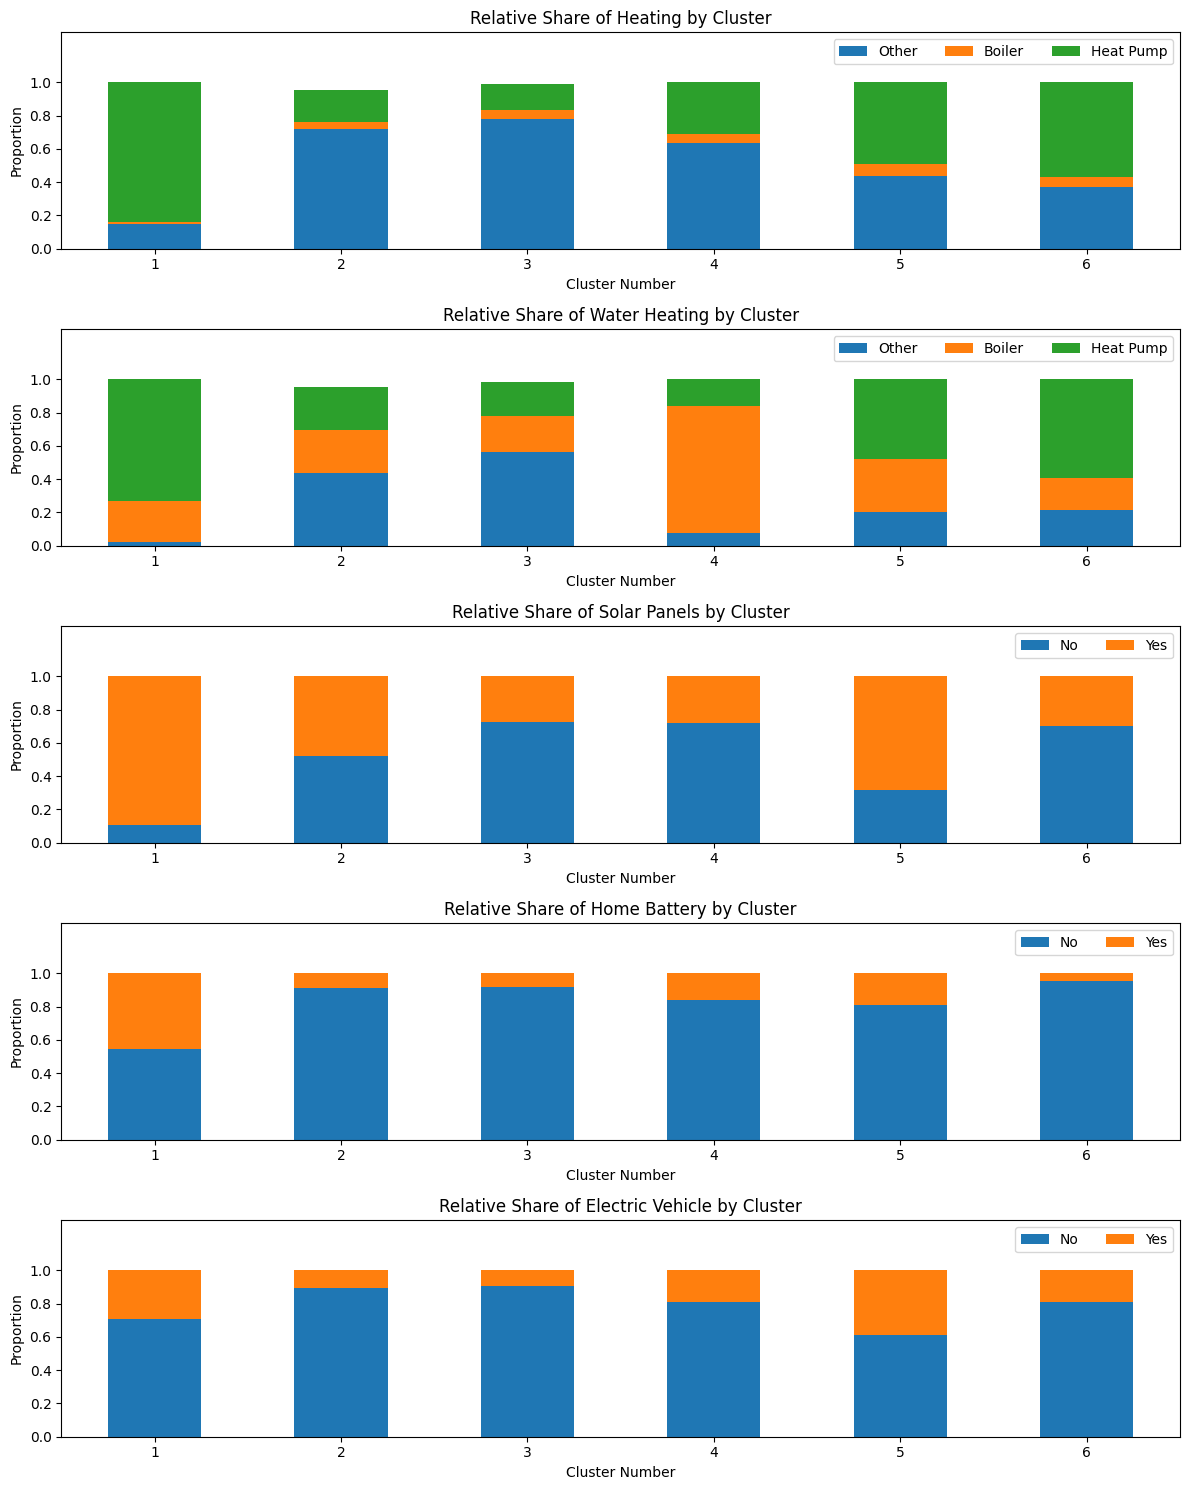

In [14]:
custom_category_orders = {
    'Solar Panels': ['No', 'Yes'],
    'Electric Vehicle': ['No', 'Yes'],
    'Water Heating': ['Other', 'Boiler', 'Heat Pump'],
    'Heating': ['Other', 'Boiler', 'Heat Pump'],
    'Home Battery': ['No', 'Yes'],
    'Individual Electric Boiler': ['No', 'Yes'],
    'Individual Washing Machine': ['No', 'Yes'],
}

if building_type == 'flat':
    category_features = ['Individual Electric Boiler', 'Individual Washing Machine']
else:
    category_features = ['Heating', 'Water Heating', 'Solar Panels', 'Home Battery', 'Electric Vehicle']

n_features = len(category_features)

final_df_plot = final_df.to_pandas()

fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    # Group and pivot data for plotting
    counts = final_df_plot.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Apply custom category order
    order = custom_category_orders[feature]
    proportions = proportions.reindex(columns=order)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Relative Share of {feature.title()} by Cluster')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Cluster Number')
    ax.set_ylim(0, 1.3)  # y-axis goes up to 1.3 to allow space above bars
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(
        loc='upper right',
        bbox_to_anchor=(1, 1),
        ncol=len(order),  # one column per category
        fontsize='medium'
    )
    display(proportions.round(3))
plt.tight_layout()
plt.savefig(
f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Survey/{data_type}_technical.png'
)
plt.show()

Tenant Type,Living in a cooperative,Tenant,Owner
cluster,,,
1,0.000,0.035,0.965
2,0.065,0.152,0.783
3,0.008,0.129,0.863
4,0.029,0.118,0.853
5,0.000,0.043,0.957
6,0.012,0.060,0.928


Age,18-35 years old,36 - 50 years old,51 - 65 years old,More than 65 years old
cluster,,,,
1,0.012,0.140,0.372,0.477
2,0.000,0.283,0.348,0.370
3,0.048,0.331,0.323,0.298
4,0.029,0.221,0.294,0.456
5,0.014,0.174,0.420,0.391
6,0.000,0.398,0.313,0.289


Income,I prefer not to say,"Less than 4,000","4,000-5,999",6000-9999,10000 CHF or more
cluster,,,,,
1,0.093,0.023,0.116,0.244,0.523
2,0.109,0.109,0.152,0.348,0.283
3,0.129,0.008,0.065,0.387,0.411
4,0.118,0.059,0.088,0.412,0.324
5,0.087,0.029,0.043,0.391,0.449
6,0.193,0.012,0.048,0.241,0.506


Education,Mandatory school,"Secondary degree (Apprenticeship, high school et commercial/general culture school)","Tertiary degree (Superior school (ES), University/EPF, vocational university)"
cluster,,,
1,0.023,0.128,0.849
2,0.000,0.196,0.804
3,0.024,0.202,0.774
4,0.044,0.265,0.691
5,0.043,0.159,0.797
6,0.000,0.133,0.867


Employment,Employed,Unemployed,Retired
cluster,,,
1,0.733,0.000,0.267
2,0.804,0.000,0.196
3,0.782,0.008,0.210
4,0.632,0.000,0.368
5,0.739,0.000,0.246
6,0.831,0.000,0.169


Number of Days at Home,0,1,2,3,4,5,6,7
cluster,,,,,,,,
1,0.012,0.023,0.035,0.081,0.105,0.070,0.081,0.593
2,0.000,0.043,0.043,0.043,0.174,0.087,0.130,0.478
3,0.000,0.008,0.073,0.081,0.153,0.113,0.153,0.419
4,0.015,0.044,0.059,0.029,0.221,0.074,0.059,0.500
5,0.014,0.000,0.058,0.087,0.130,0.145,0.087,0.478
6,0.012,0.012,0.024,0.024,0.205,0.145,0.120,0.458


Number of Residents,1,2,3,4,> 4
cluster,,,,,
1,0.221,0.523,0.081,0.070,0.105
2,0.196,0.457,0.130,0.130,0.087
3,0.258,0.484,0.105,0.081,0.073
4,0.235,0.588,0.088,0.044,0.044
5,0.217,0.464,0.145,0.087,0.087
6,0.217,0.470,0.133,0.133,0.048


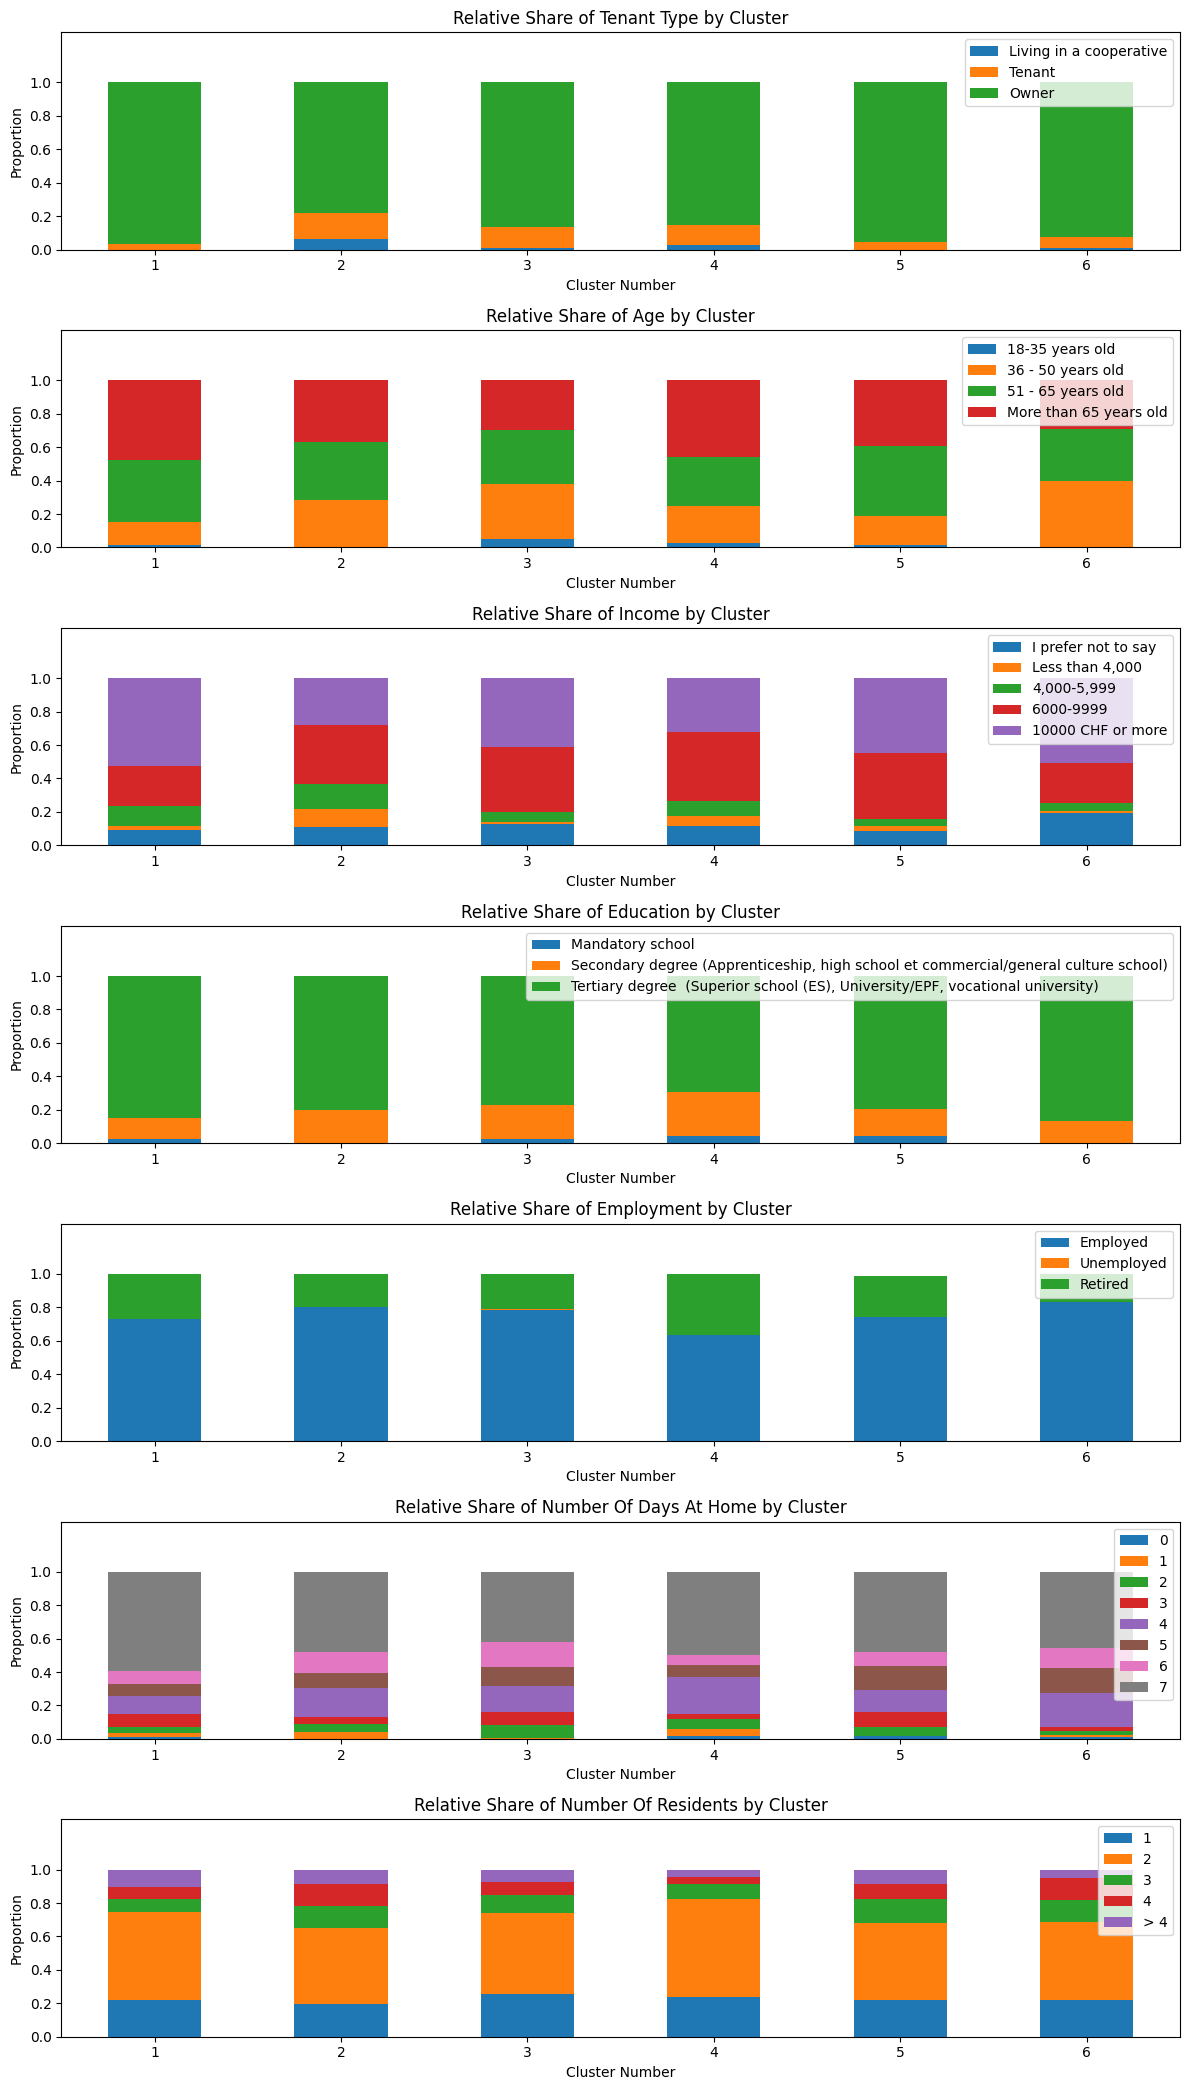

In [15]:
# Demographic Features Plotting
custom_category_orders = {
    'Tenant Type': ['Living in a cooperative', 'Tenant', 'Owner'],
    'Age': ['18-35 years old', '36 - 50 years old', '51 - 65 years old', 'More than 65 years old'],
    'Income': ['I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ],
    'Education': ['Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)', 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)'],
    'Employment': ['Employed', 'Unemployed', 'Retired'],
    'Number of Residents':['1', '2', '3', '4', '> 4'],
    'Number of Days at Home': ['0', '1', '2', '3', '4', '5', '6', '7']
}

category_features = ['Tenant Type', 'Age', 'Income', 'Education', 'Employment', 'Number of Days at Home', 'Number of Residents']
n_features = len(category_features)

final_df_plot = final_df.to_pandas()

fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    # Group and pivot data for plotting
    counts = final_df_plot.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Apply custom category order
    order = custom_category_orders[feature]
    proportions = proportions.reindex(columns=order)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Relative Share of {feature.title()} by Cluster')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Cluster Number')
    ax.set_ylim(0, 1.3)  # y-axis goes up to 1.3 to allow space above bars
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(
        loc='upper right',
        bbox_to_anchor=(1, 1),
        ncol=1,  # one column per category
        fontsize='medium'
    )
    display(proportions.round(3))
plt.tight_layout()
plt.savefig(
f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Survey/{data_type}_demographic.png'
)


plt.show()